# NHSBSA English Prescribing Data (EPD) Analysis

## Part 2:  SQL, AWS EC2 Instance and Exploratory Data Analysis

### SQL for Extraction of NHS Prescribing Data

Within part one, I found that it it would take above 20minutes depending on bandwidth to extract two datasets. This is inefficient. Here, SQL is used.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests

import warnings
warnings.filterwarnings('ignore')  #This is required for filtering warnings when querying the CKAN API using SQL

import time

import scipy.stats as stats
import pylab

The construction of the base url within the function below as well as refinement of the function was done with assistance from this repo and its author, Adam Ivison. https://gitlab.com/nhsbsa/insight/shared/coffee-and-coding/-/blob/master/2021-05-19%20Get%20to%20grips%20with%20R%20and%20Python%20on%20our%20Open%20Data%20Portal/Python.ipynb

The function below originally included AREA_TEAM_NAME however, STPs were introduced in 2020 and this resulted in changes to the column names.
This causes the algorithm to fall into an infinite loop (see the while loop).
As such, odp_api_query_list function will pull post_code as only geographical indicator and will then be mapped to more recent organisations/structures.

In [2]:
def odp_api_query_list(list_of_resources):
    
    """
    This function takes a list of 'resources', as termed within the CKAN API used by the NHSBSA 
    and returns a single dataframe. The features selected from the resources can be seen in the 'query'
    variable.
    
    NOTE: A change in NHS organisational structure means that resources prior to April 2020 use a "AREA TEAM"
    feature whilst those after use "STP". When querying the API those features should not be used if data is required
    for periods of time before and after unless they are to be obtained separately.
    
    """
    
    base_endpoint = "https://opendata.nhsbsa.net/api/3/action"
    action_method = "/datastore_search_sql?" # SQL 
    
    dfs=[]
    for resource_name in list_of_resources:

        query = f"""
        SELECT 
        YEAR_MONTH,
        PRACTICE_NAME,
        POSTCODE,
        BNF_CHEMICAL_SUBSTANCE,
        CHEMICAL_SUBSTANCE_BNF_DESCR,
        SUM(TOTAL_QUANTITY) AS TOTAL_QUANTITY,
        SUM(ACTUAL_COST)    AS ACTUAL_COST

        FROM 
        `{resource_name}`     

        WHERE
        1=1
        AND CHEMICAL_SUBSTANCE_BNF_DESCR IN ('Cetirizine hydrochloride', 
        'Loratadine', 
        'Fexofenadine hydrochloride', 
        'Acrivastine', 
        'Bilastine', 
        'Levocetirizine', 
        'Mizolastine', 
        'Chlorphenamine maleate', 
        'Promethazine hydrochloride')

        AND BNF_DESCRIPTION NOT IN ('Promethazine 25mg/1ml solution for injection ampoules', 
        'Phenergan 25mg/1ml solution for injection ampoules')

        GROUP BY
        YEAR_MONTH,
        PRACTICE_NAME,
        POSTCODE,
        BNF_CHEMICAL_SUBSTANCE,
        CHEMICAL_SUBSTANCE_BNF_DESCR
        """
        
        #I found that the same query run multiple times may sometimes produce an error.
        #To combat this, the API call will be repeated up to 10 times but will break earlier if 'error' is not 
        #within the response.
        
        num_attempts = 10
        for _ in range(num_attempts):

            # Send API call and grab the response as a json
            response = requests.get(
            url=(
            base_endpoint 
            + action_method 
            + "resource_id=" + resource_name
            + "&"
            + "sql=" + requests.utils.quote(query) # Encode url
            ),
            verify=False
            ).json()

            if 'error' not in response:
                break
                
        
        
        #When the data is too large, the API presents a list. This is expected for the query constructed.
        
        try:
            df = pd.read_csv(response['result']['gc_urls'][0]['url'])

        
        #Where the data is small enough, it'll be provided in JSON format. Therefore, an attempt to read a url
        #will produce an error which will be ignored in favour of an attempt to read the dictionary.
        
        except KeyError:
            df = pd.DataFrame(response['result']['result']['records'])


        dfs.append(df)
                
    final_df = pd.concat(dfs)
                
    return final_df

In [3]:
def timefunc(function, arg, repeats = 20):
    
    alltime = []
    
    while  repeats > 0:
        
        """
        repeats: Use int value type. 
                 Unless specified, the number of repitions will be 20.
                 More repititions will enable the collection of reliable run-times, however,
                 this will come at the cost of time.
                 
        Mean, standard deviation and standard error are all calculated. For the purpose of this project,
        only the mean will br returned in this function.
        """
        
        starttime= time.time() # record the start time

        result = function(arg) # run the function and store in the variable 'result' in case result is needed.

        endtime = time.time() # Record end time.

        timetaken = endtime - starttime 
        
        alltime.append(timetaken) 
        
        repeats -=1  
        
    mean = np.mean(alltime) #Find the mean.
    std = np.std(alltime) #Find the standard deviation.
    error=std/(len(alltime)**0.5)   #Find the standard error.
    
    return (mean)

In [4]:
#Below, a list of 'resources' in the same naming format used by the NHSBSA is constructed for the years required.
years = [19,20,21]
months = list(range(1, 13))
resources = []
for year in years:
    resource_name_year = "EPD_20"+str(year)
    for month in months:
        resource_names = resource_name_year+str(month).zfill(2)
        #The zfill function adds a 0 to the begining of a string until it reaches the specified length. 
        #A length of 2 is in line witht the name format for single digit months in NHSBSA naming format.
        
        resources.append(resource_names)

        
EPDs_needed = resources[:29]

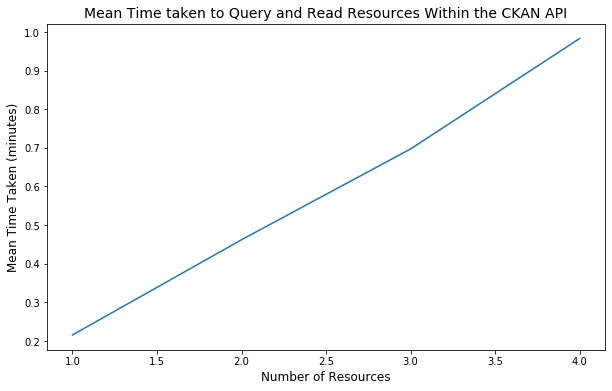

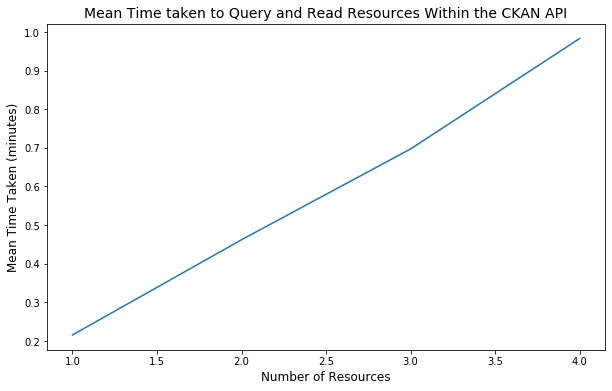

In [5]:
#The time taken to query and read more than one resource at a time is recorded and plotted.
#The time it will take to read all 29 months/resources will then be calculated using this data.

x_axis = []
y_axis = []

for num in range(5)[1:]:
    x_axis.append(num)
    
    timetaken = timefunc(odp_api_query_list, EPDs_needed[:num], repeats=3)
    y_axis.append(timetaken/60)


fig,ax1=plt.subplots(figsize=(10,6))

plt.xlabel('Number of Resources', fontsize =12)
plt.ylabel('Mean Time Taken (minutes)', fontsize =12)
plt.title('Mean Time taken to Query and Read Resources Within the CKAN API', fontsize =14)

            
sns.lineplot(x=x_axis, y=y_axis)

January 2019 to May 2021 = 29months (29 iterations for iterations within the odp_api_query_list function)

In [6]:
slope, intercept, r, p, se = stats.linregress(x_axis, y_axis)
print("Slope is {} and intercept is {}".format(slope,intercept))

Slope is 0.25381561795870466 and intercept is -0.04508511159155104
Slope is 0.25381561795870466 and intercept is -0.04508511159155104


In [7]:
y = slope*30 +intercept
print ("If this algorithm/function follows O(n) or linear-time algorithmic complexity, roughly {} mintues will be needed to extract and read EPD datasets from January 2019 to June 2021.".format(y.round(2)))

If this algorithm/function follows O(n) or linear-time algorithmic complexity, roughly 7.57 mintues will be needed to extract and read EPD datasets from January 2019 to June 2021.
If this algorithm/function follows O(n) or linear-time algorithmic complexity, roughly 7.57 mintues will be needed to extract and read EPD datasets from January 2019 to June 2021.


In [8]:
EPD2019_2021_oralantihistamines = odp_api_query_list(EPDs_needed)

<b> Beware, Pandas.to_datetime does NOT repect exact formatting despite usage of the kwargs. </b>

In [9]:
EPD2019_2021_oralantihistamines.YEAR_MONTH = pd.to_datetime(EPD2019_2021_oralantihistamines.YEAR_MONTH,exact = True, format= '%Y%m', infer_datetime_format=False)
EPD2019_2021_oralantihistamines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184611 entries, 0 to 40335
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   YEAR_MONTH                    1184611 non-null  datetime64[ns]
 1   PRACTICE_NAME                 1184611 non-null  object        
 2   POSTCODE                      1181948 non-null  object        
 3   BNF_CHEMICAL_SUBSTANCE        1184611 non-null  object        
 4   CHEMICAL_SUBSTANCE_BNF_DESCR  1184611 non-null  object        
 5   TOTAL_QUANTITY                1184611 non-null  float64       
 6   ACTUAL_COST                   1184611 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 72.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184611 entries, 0 to 40335
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                 

In [10]:
EPD2019_2021_oralantihistamines.to_csv('EPD2019_2021_oralantihistamines.csv')

Postcode to Output Area Hierarchy with Classifications (August 2020) Lookup in the UK. Will be used to map post codes to locations. ONS categorisation of such postcodes will also be used in EDA.
  
https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-hierarchy-with-classifications-august-2020-lookup-in-the-uk/about

In [11]:
ONS_data = pd.read_csv('NSPCL_AUG20_UK_LU.csv')
ONS_required_data = ONS_data[['ladnm','pcds','soac11nm']]
New_EPD2019_2021 = EPD2019_2021_oralantihistamines.merge(ONS_required_data, how = 'left', left_on= 'POSTCODE', right_on ='pcds').drop(columns = ['pcds']).rename(columns ={'ladnm':'Local_Authority_District', 'soac11nm': 'Area_Classification' })

In [12]:
New_EPD2019_2021.head(3)

,YEAR_MONTH,PRACTICE_NAME,POSTCODE,BNF_CHEMICAL_SUBSTANCE,CHEMICAL_SUBSTANCE_BNF_DESCR,TOTAL_QUANTITY,ACTUAL_COST,Local_Authority_District,Area_Classification
0,2019-01-01,DR M EHSAN,RM10 9ET,0304010AF,Bilastine,56.0,26.25832,Barking and Dagenham,Urban cultural mix
1,2019-01-01,LUCAS AVENUE PRACTICE,E13 0QP,0304010AF,Bilastine,30.0,14.01815,Newham,Young ethnic communities
2,2019-01-01,THE SNAITH AND RAWCLIFFE MEDICAL GROUP,DN14 9DY,0304010AF,Bilastine,30.0,14.00575,East Riding of Yorkshire,Rural traits


,YEAR_MONTH,PRACTICE_NAME,POSTCODE,BNF_CHEMICAL_SUBSTANCE,CHEMICAL_SUBSTANCE_BNF_DESCR,TOTAL_QUANTITY,ACTUAL_COST,Local_Authority_District,Area_Classification
0,2019-01-01,DR M EHSAN,RM10 9ET,0304010AF,Bilastine,56.0,26.25832,Barking and Dagenham,Urban cultural mix
1,2019-01-01,LUCAS AVENUE PRACTICE,E13 0QP,0304010AF,Bilastine,30.0,14.01815,Newham,Young ethnic communities
2,2019-01-01,THE SNAITH AND RAWCLIFFE MEDICAL GROUP,DN14 9DY,0304010AF,Bilastine,30.0,14.00575,East Riding of Yorkshire,Rural traits


### Met Office Pollen Count Data
## Information provided by the National Meteorological Library and Archive – Met Office, UK.

Below is an example of one dataset read to a Dataframe. This will help to understand the struture of the resulting dataframe and constuction of an algorithm to read them all to a suitable format.

In [13]:
df = pd.read_excel('PollenStationData2011.xlsx', sheet_name =None)
df_new = pd.concat(df)
df_new

Data provided by the National Meteorological Archive must not be used in any legal dispute or insurance claim. Data for this purpose can be obtained by contacting the Met Office Customer Centre at:  \
INFO 0    Tel: 0870 900 0100  Email:  enquiries@metoffic...                                                                                                                                                      
     1    All data values are subject to Quality Control...                                                                                                                                                      
     2    All information originating from the Met Offic...                                                                                                                                                      
     3    Please refer to the following guidance OGL Ack...                                                                                                                                                      
     4                                        Pollen Types:                                                                                                                                                      
...                                                     ...                                                                                                                                                      
York 153                                                NaN                                                                                                                                                      
     154                                                NaN                                                                                                                                                      
     155                                                NaN                                                                                                                                                      
     156                                                NaN                                                                                                                                                      
     157                                                NaN                                                                                                                                                      

               Date Cory  Alnu  Sali  Betu  Frax  Ulmu  Quer  Plat  Poac  \
INFO 0          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     1          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     2          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     3          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     4          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...             ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
York 153 2011-08-21    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
     154 2011-08-22    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
     155 2011-08-23    0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
     156 2011-08-24    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
     157 2011-08-25    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

          Urti  Arte  Ambr  
INFO 0     NaN   NaN   NaN  
     1     NaN   NaN   NaN  
     2     NaN   NaN   NaN  
     3     NaN   NaN   NaN  
     4     NaN   NaN   NaN  
...        ...   ...   ...  
York 153   9.0   0.0   0.0  
     154   9.0   0.0   0.0  
     155   4.0   0.0   0.0  
     156   3.0   0.0   0.0  
     157   1.0   0.0   0.0  

[2447 rows x 14 columns]

Data provided by the National Meteorological Archive must not be used in any legal dispute or insurance claim. Data for this purpose can be obtained by contacting the Met Office Customer Centre at:  \
INFO 0    Tel: 0870 900 0100  Email:  enquiries@metoffic...                                                                                                                                                      
     1    All data values are subject to Quality Control...                                                                                                                                                      
     2    All information originating from the Met Offic...                                                                                                                                                      
     3    Please refer to the following guidance OGL Ack...                                                                                                                                                      
     4                                        Pollen Types:                                                                                                                                                      
...                                                     ...                                                                                                                                                      
York 153                                                NaN                                                                                                                                                      
     154                                                NaN                                                                                                                                                      
     155                                                NaN                                                                                                                                                      
     156                                                NaN                                                                                                                                                      
     157                                                NaN                                                                                                                                                      

               Date Cory  Alnu  Sali  Betu  Frax  Ulmu  Quer  Plat  Poac  \
INFO 0          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     1          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     2          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     3          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     4          NaT  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...             ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
York 153 2011-08-21    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
     154 2011-08-22    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
     155 2011-08-23    0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
     156 2011-08-24    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
     157 2011-08-25    0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

          Urti  Arte  Ambr  
INFO 0     NaN   NaN   NaN  
     1     NaN   NaN   NaN  
     2     NaN   NaN   NaN  
     3     NaN   NaN   NaN  
     4     NaN   NaN   NaN  
...        ...   ...   ...  
York 153   9.0   0.0   0.0  
     154   9.0   0.0   0.0  
     155   4.0   0.0   0.0  
     156   3.0   0.0   0.0  
     157   1.0   0.0   0.0  

[2447 rows x 14 columns]

In [14]:
#List of excel files containing pollen count provided by the MET Office.
Met_Pollen_Data = ['PollenStationData2011.xlsx',
                   'PollenStationData2012.xlsx', 
                   'PollenStationData2013.xlsx', 
                   'PollenStationData2014.xlsx', 
                   'PollenStationData2015.xlsx', 
                   'PollenStationData2016.xlsx',
                   'PollenStationData2017.xlsx', 
                   'PollenStationData2018.xlsx', 
                   'PollenStationData2019.xlsx',
                   'PollenStationData2020.xlsx', 
                   'PollenStationData2021vs30June.xlsx']

#A dictionary that will be used to rename the columns in the MET Office Excel files.
Pollen_types = {'Cory':'Hazel_Pollen',
                'Alnu': 'Alder_Pollen',
                'Sali':'Willow_Pollen',
                'Betu': 'Birch_Pollen',
                'Frax': 'Ash_Pollen',
                'Ulmu':'Elm_Pollen',
                'Quer':'Oak_Pollen',
                'Plat':'Plane_(tree)_Pollen',
                'Poac':'Grass_Pollen',
                'Urti':'Nettle_Pollen',
                'Arte':'Mugwort_Pollen',
                'Ambr': 'Ragweed_Pollen'}

#List of location pollen counts are recorded in according to the MET office.

collection_locations_list = ['Bath', 
          'Belfast',
          'Cambridge', 
          'Cardiff', 
          'East Riding',
          'Edinburgh', 
          'Eskdalemuir', 
          'Exeter', 
          'Hull', 
          'Invergowrie',
          'Ipswich', 
          'Isle of Wight', 
          'Leicester', 
          'London, Islington',
          'London, Kings College', 
          'Plymouth', 
          'Rotherham', 
          'Worcester',
          'York', 
          'Chester', 
          'I-o-W', 
          'Kings College', 
          'Exeter Uni'
                            ]

location_number = list(range(1,200))

#Dictionary which will be used to replace values in the following cell. The .zip() function has been used to turn two lists from above into a dictionary

collection_locations = dict(zip(collection_locations_list, location_number))

#Key-Value pairs swapped to undo or redo replacements.
inverse_collection_locations = {v: k for k, v in collection_locations.items()}

In [15]:
dfs=[]
for pollen_data in Met_Pollen_Data:
    
    #This first reading of a excel file with multiple sheets produces a dictionary.
    df = pd.read_excel(pollen_data, sheet_name =None)
    
    #Each key is a sheet name and each sheet name is the location in which pollen count data is collected.
    for location in list(df.keys()):
        df[location]['Location']= location
    
    #Concatenate each dictionary to form a dataframe
    df_new = pd.concat(df)
    
    #Append each dataframe to the originally empty list, dfs.
    dfs.append(df_new)
    
    #Concatenate all the dataframes to form one final dataframe.
    met_pollen_df =pd.concat(dfs)

#Drop the column created by the 'INFO sheet'
#It is useful to read it before analysis but it is not needed in the dataframe.
met_pollen_df = met_pollen_df.drop(['Data provided by the National Meteorological Archive must not be used in any legal dispute or insurance claim. Data for this purpose can be obtained by contacting the Met Office Customer Centre at:'],axis=1)

#Remove all rows in which the value in the location field is 'INFO'
met_pollen_df = met_pollen_df[met_pollen_df['Location'] !='INFO']

#Set the index to the 'Date column'. This will be undone and is to prevent the conversion of the column to int later.
met_pollen_df = met_pollen_df.set_index('Date')

#Rename all pollen values with the dictionary created above using information from the 'INFO' sheet.
met_pollen_df.rename(mapper=Pollen_types, axis=1, inplace=True)

#Cheange location values to int using the dictionary above to avoid loss when to_numeric is used.
met_pollen_df = met_pollen_df.replace(collection_locations)

#-1 values will negatively impact calculations. Replace with 0. See 'INFO' sheet for meaning of -1.
met_pollen_df = met_pollen_df.replace({-1:0})

#GConvert all str values to numeric.
#Fill all NaN with 0 from string which could not be converted.
met_pollen_df = met_pollen_df.apply(pd.to_numeric, errors='coerce').fillna(value= 0, axis = 1)

#Change location values back to original string using the inverse of the original dictionary above.
met_pollen_df.Location = met_pollen_df['Location'].replace(inverse_collection_locations)

#Reset the index, the 'Date' field is not suitable as there are duplicates. Is not time-series.
met_pollen_df = met_pollen_df.reset_index()

#Ensure the 'Date' column is in datetime format.
met_pollen_df['Date'] = pd.to_datetime(met_pollen_df['Date'])

### AWS EC2 Instance

#### Steps required to connect to a Linus instance using SSH

1. Within EC2 create a security group.
   In this example, one of the outbound rules must specify:
   
   <u>Inbound rule 1</u>
       Type: Custom TCP Port 
       Port Range: e.g. 9999
       Source: 0.0.0.0/0 (anywhere)
       Protocol: TCP
       
   <u>Inbound rule 2</u>
       Type: Custom SSH
       Port Range: 22 (default)
       Source: 0.0.0.0/0 (anywhere)
       Protocol: TCP
       
   <u>Outbound rule </u>
       Type: All Traffic
       Port Range: All
       Source: 0.0.0.0/0 (anywhere)
       Protocol: All
       
2. Initiate an instance. The choice is yours, free instances are available.

3. <b><font color='red'>Ensure the .pem key is downloaded !!</font> </b>
4. Assign the security group to the instance.
5. Fire up your terminal (mac)
    - Navigate to the correct folder/location, the ls and cd commands alongside the tab key will be most useful.
    - Enter ssh -i [pem-file-name].pem ec2-user@[public-IP]
    - Read AWS guidance (link below) to understand the risks and confirm 'yes' to:
        
        <i> The authenticity of host 'ec2-198-51-100-1.compute-1.amazonaws.com (198-51-100-1)' can't be established. ECDSA key fingerprint is l4UB/neBad9tvkgJf1QZWxheQmR59WgrgzEimCG6kZY.
Are you sure you want to continue connecting (yes/no)? </i>


    - Run "sudo yum install python3" to ensure you have the right version of python within the instance.

#### Running a function

1. A .py file (example code below)containing instructions for the server (instance) should be sent to root directory of the instnace using (within the terminal):
    
    scp -i [pem-file-name].pem [file-name].py ec2-user@[Public IP]:~/
    
   
2. The client machine can then run the function, freeing the local CPU to complete other tasks. 


Guidance document for connecting to an instance. https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/AccessingInstancesLinux.html

Example code below.

#### Server

In [ ]:
from xmlrpc.server import SimpleXMLRPCServer
import logging

from multiprocessing import Process

def runServer():
    server = SimpleXMLRPCServer(
        ('0.0.0.0', 9999),
        logRequests=True,
    )
    server.register_function(odp_api_query_list)
    # Start the server
    try:
        print('Use Control-C to exit')
        server.serve_forever()
    except KeyboardInterrupt:
        print('Exiting')
        
def function_name(args, kwargs):
    
    return requred_result

p = Process(target=runServer) #Run the function within the server, not the local machine/client.
p.start()

#### Client

In [ ]:
import xmlrpc.client
proxy = xmlrpc.client.ServerProxy('http://[public IP]:9999')

proxy.function_name(args, kwargs)

### Exploratory Data Analysis (with a focus on EPD)

In [16]:
EPD_2019 = New_EPD2019_2021[New_EPD2019_2021['YEAR_MONTH']<= '2019-12-31'] #Before the COVID19 pandemic.
EPD_2021 = New_EPD2019_2021[New_EPD2019_2021['YEAR_MONTH']>= '2021-01-01'] #Data relevant to the present.
EPD_2020 = New_EPD2019_2021[(New_EPD2019_2021['YEAR_MONTH']<= '2020-12-31') &(New_EPD2019_2021['YEAR_MONTH']>= '2020-01-01')]
pollen_2019_2021 = met_pollen_df[(met_pollen_df['Date']>'2018-12-31') & (met_pollen_df['Date']<'2021-06-01')]

Overall prescribing of antihistamines by total quantity overllapped with pollen counts.

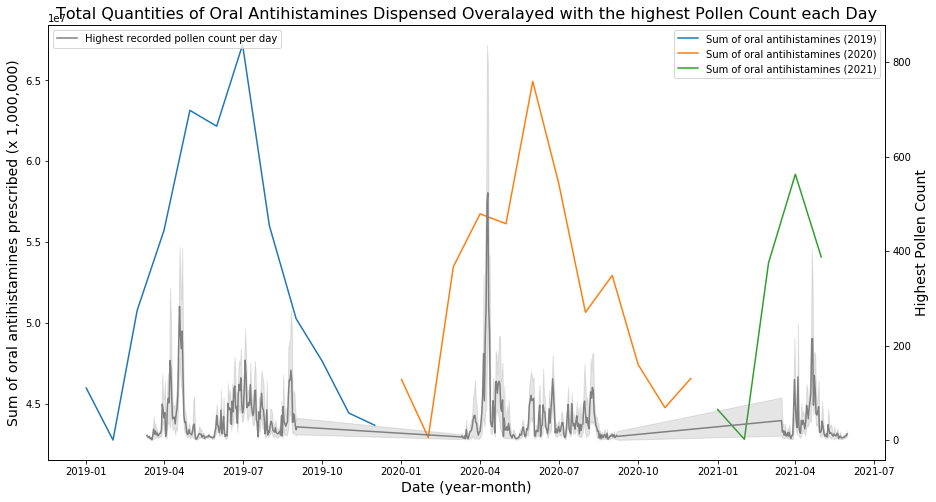

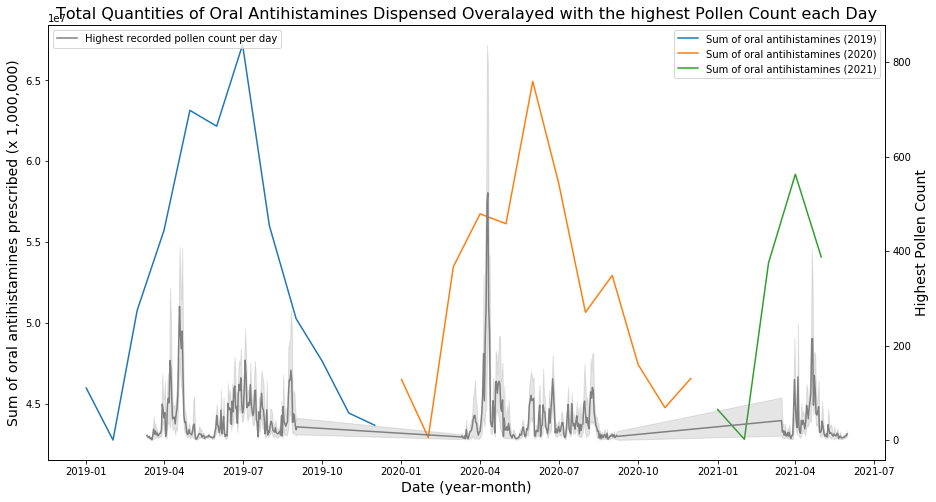

In [17]:
sum_EPD_2019 = EPD_2019.groupby(by=['YEAR_MONTH']).sum()
sum_EPD_2020 = EPD_2020.groupby(by=['YEAR_MONTH']).sum()
sum_EPD_2021 = EPD_2021.groupby(by=['YEAR_MONTH']).sum()

fig,ax1=plt.subplots(figsize=(15,8))

sns.lineplot(data=sum_EPD_2019,x= sum_EPD_2019.index,y='TOTAL_QUANTITY')
sns.lineplot(data=sum_EPD_2020,x= sum_EPD_2020.index,y='TOTAL_QUANTITY')
sns.lineplot(data=sum_EPD_2021,x= sum_EPD_2021.index,y='TOTAL_QUANTITY')
plt.legend(labels=['Sum of oral antihistamines (2019)',
                   'Sum of oral antihistamines (2020)',
                   'Sum of oral antihistamines (2021)',
                   ], loc= 'upper right')

plt.xlabel('Date (year-month)', fontsize=14)
plt.ylabel('Sum of oral antihistamines prescribed (x 1,000,000)', fontsize=14)
plt.title('Total Quantities of Oral Antihistamines Dispensed Overalayed with the highest Pollen Count each Day'
          ,fontsize = 16)

ax2 = ax1.twinx()

sns.lineplot(data = pollen_2019_2021, x = pollen_2019_2021.Date, y= pollen_2019_2021.max(axis=1), color='grey')
plt.ylabel('Highest Pollen Count', fontsize=14 )
plt.legend(labels=['Highest recorded pollen count per day'], loc= 'upper left')

Prescribing quantities appear to be normally distributed over each year. Will confirm using a probability plot (visual) and shapiro-wilk test.

Text(0.5, 1.0, 'Probability Plot of Sum of Total Quantities')

Text(0.5, 1.0, 'Probability Plot of Sum of Total Quantities')

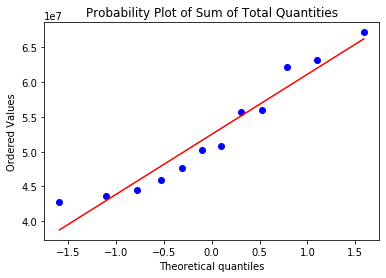

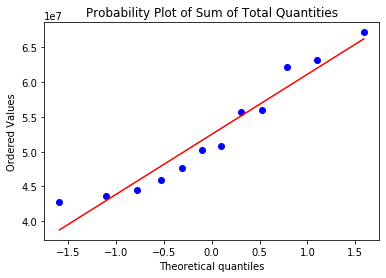

In [18]:
stats.probplot(sum_EPD_2019['TOTAL_QUANTITY'], dist = "norm", plot =pylab)
plt.title(label ='Probability Plot of Sum of Total Quantities')

In [19]:
stats.shapiro(sum_EPD_2019['TOTAL_QUANTITY'])

(0.9181531667709351, 0.2709859609603882)

(0.9181531667709351, 0.2709859609603882)

P value is above significance level of 0.05, the data has a <b>normal distribution</b>.

2021 so far...

The boxplot below shows the spread of prescribing quantity by drug. 
Presence of outliers at higher total quantity values (negative skew) will make the mean more biased towards higher values. Median will be more suitable measure of central tendency.

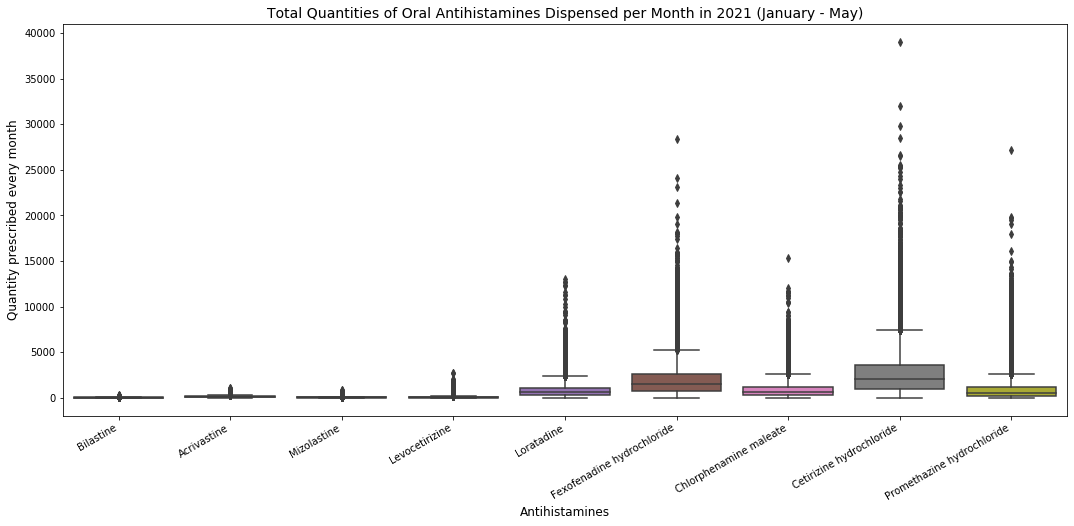

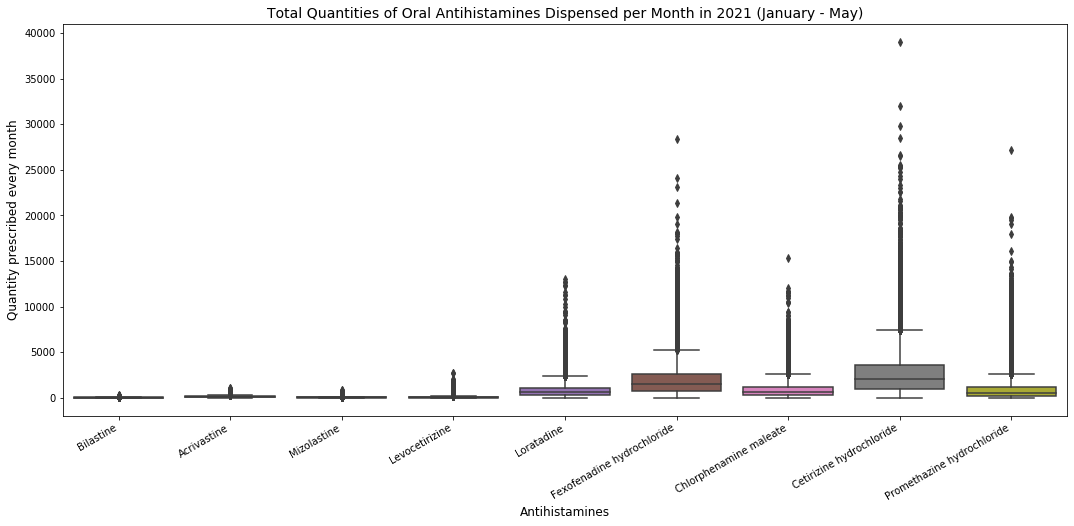

In [20]:
fig,ax1=plt.subplots(figsize=(18,8))
sns.boxplot(data=sum_EPD_2021, x=EPD_2021.CHEMICAL_SUBSTANCE_BNF_DESCR,y=EPD_2021.TOTAL_QUANTITY )

plt.title('Total Quantities of Oral Antihistamines Dispensed per Month in 2021 (January - May)',fontsize = 14)
plt.xlabel('Antihistamines', fontsize=12)
plt.ylabel('Quantity prescribed every month', fontsize=12)
fig.autofmt_xdate()

Both the boxplot above and the lineplot below confirm Cetirizine is prescribed in the highest quantities. It is available OTC so this was unexpected.

Text(0, 0.5, 'Total quantity prescribed')

Text(0, 0.5, 'Total quantity prescribed')

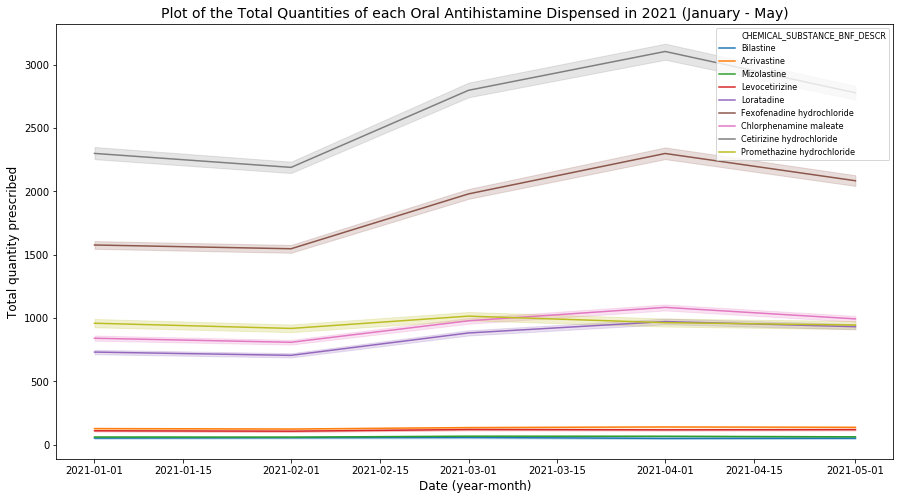

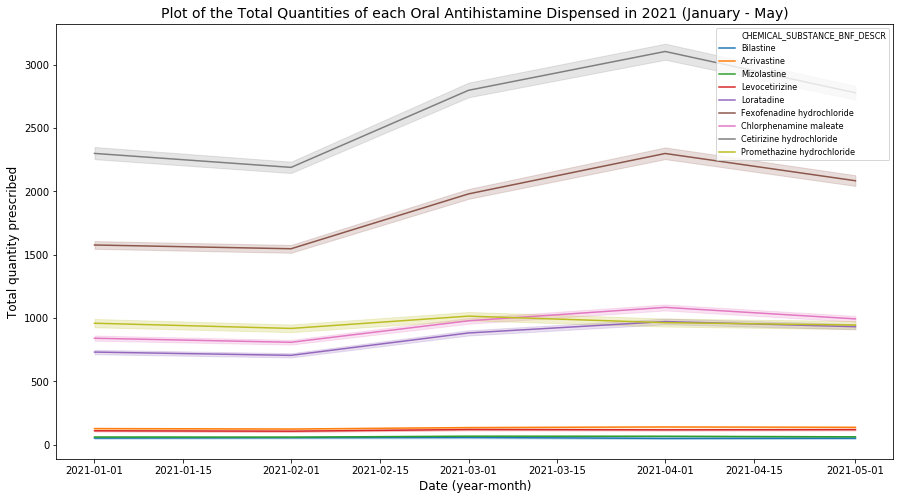

In [21]:
fig,ax1=plt.subplots(figsize=(15,8))

sns.lineplot(data=EPD_2021,x= 'YEAR_MONTH',y='TOTAL_QUANTITY', hue = 'CHEMICAL_SUBSTANCE_BNF_DESCR')
plt.legend(fontsize=8)
plt.title('Plot of the Total Quantities of each Oral Antihistamine Dispensed in 2021 (January - May)',fontsize = 14)
plt.xlabel('Date (year-month)', fontsize=12)
plt.ylabel('Total quantity prescribed', fontsize=12)

ONS Local Area Classification and antihistamine prescribing.

In [22]:
median_EPD_2021_soac = EPD_2021.groupby(by=['Area_Classification']).median().sort_values(by='TOTAL_QUANTITY',ascending=False)
median_EPD_2021_soac.head(5)

,TOTAL_QUANTITY,ACTUAL_COST
Area_Classification,,
Constrained renters,886.5,41.722420
Ageing urban communities,850.0,41.731420
Primary sector workers,842.0,42.789810
Households in terraces and flats,810.0,36.444955
Hampered neighbourhoods,786.0,35.773630


,TOTAL_QUANTITY,ACTUAL_COST
Area_Classification,,
Constrained renters,886.5,41.722420
Ageing urban communities,850.0,41.731420
Primary sector workers,842.0,42.789810
Households in terraces and flats,810.0,36.444955
Hampered neighbourhoods,786.0,35.773630


Text(0, 0.5, 'Median Total Quantity')

Text(0, 0.5, 'Median Total Quantity')

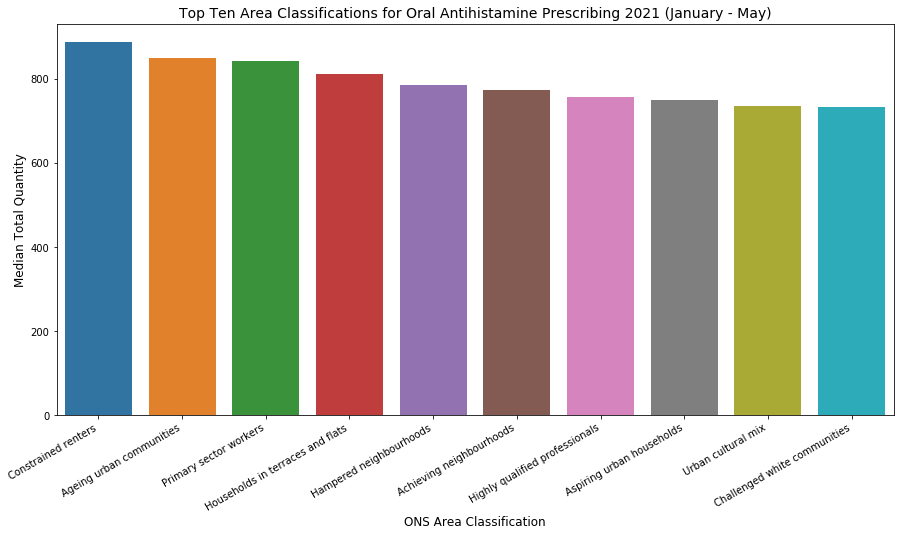

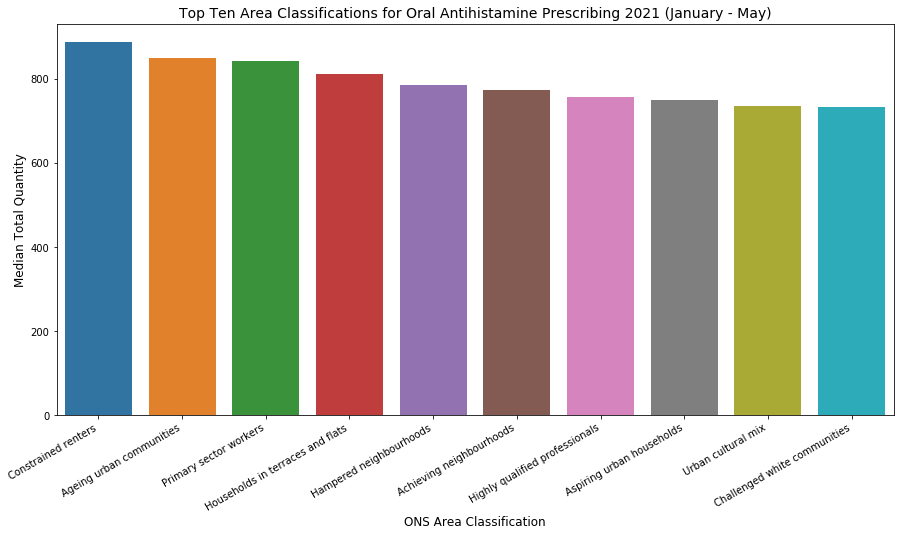

In [23]:
fig,ax1=plt.subplots(figsize=(15,8))
top_ten_areas = median_EPD_2021_soac.head(10)
sns.barplot(data=top_ten_areas, x=top_ten_areas.index, y='TOTAL_QUANTITY')
fig.autofmt_xdate()

plt.title('Top Ten Area Classifications for Oral Antihistamine Prescribing 2021 (January - May)',fontsize = 14)
plt.xlabel('ONS Area Classification', fontsize=12)
plt.ylabel('Median Total Quantity', fontsize=12)

In the year prior to June 2017, the NHS spent approximately £569 million on prescriptions for medicines which can be purchased over the counter from a pharmacy and other outlets such as supermarkets.https://www.england.nhs.uk/medicines-2/conditions-for-which-over-the-counter-items-should-not-routinely-be-prescribed/

NHS England advise "CCGs that a prescription for treatment of mild to moderate hay fever will not routinely be offered in primary care as the condition is appropriate for self-care". Annual spend, according to NHSE for mild to moderate hay fever/seasonal rhinitis was £1,100,000. https://www.england.nhs.uk/wp-content/uploads/2018/03/otc-guidance-for-ccgs.pdf

How are we doing in 2021?

In [24]:
Actual_cost_sum = EPD_2021.groupby(by='PRACTICE_NAME').sum().sort_values(by='ACTUAL_COST', ascending=False)
Actual_cost_sum.head()

,TOTAL_QUANTITY,ACTUAL_COST
PRACTICE_NAME,,
PARK SURGERY,434546.0,23717.88112
CENTRAL SURGERY,342752.0,17657.99671
THE LIMES MEDICAL CENTRE,332092.0,17209.59191
TRINITY MEDICAL CENTRE,280648.0,15913.62582
MIDLANDS MEDICAL PARTNERSHIP,335977.0,15808.93533


,TOTAL_QUANTITY,ACTUAL_COST
PRACTICE_NAME,,
PARK SURGERY,434546.0,23717.88112
CENTRAL SURGERY,342752.0,17657.99671
THE LIMES MEDICAL CENTRE,332092.0,17209.59191
TRINITY MEDICAL CENTRE,280648.0,15913.62582
MIDLANDS MEDICAL PARTNERSHIP,335977.0,15808.93533


Text(0, 0.5, 'Total Cost (£)')

Text(0, 0.5, 'Total Cost (£)')

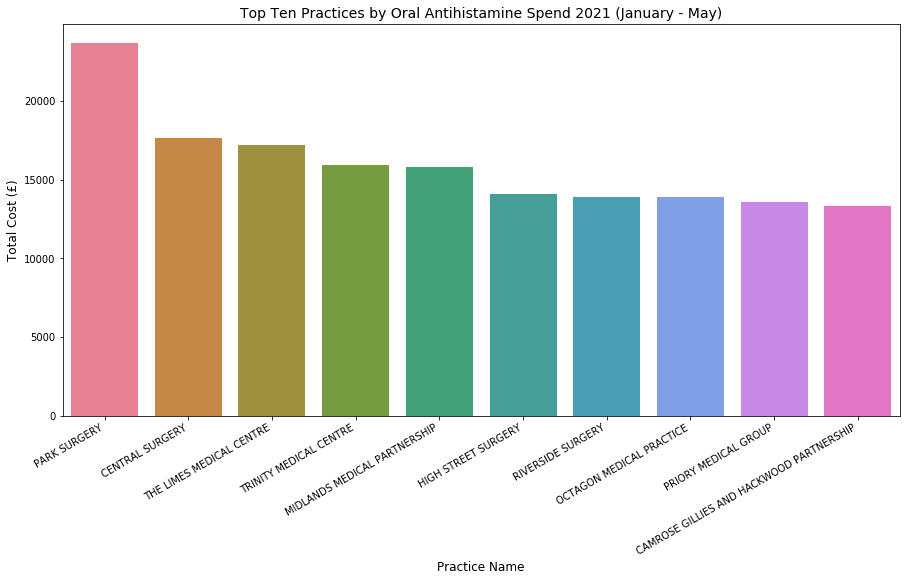

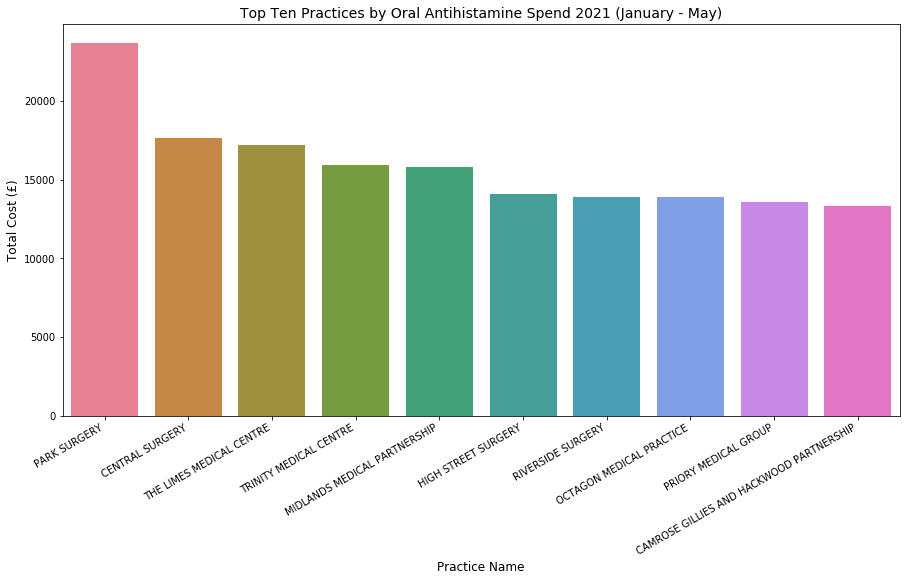

In [25]:
fig,ax1=plt.subplots(figsize=(15,8))
top_ten_Practices = Actual_cost_sum.head(10)
sns.barplot(data=top_ten_Practices, x=top_ten_Practices.index, y='ACTUAL_COST', palette= 'husl')
fig.autofmt_xdate()

plt.title('Top Ten Practices by Oral Antihistamine Spend 2021 (January - May)',fontsize = 14)
plt.xlabel('Practice Name', fontsize=12)
plt.ylabel('Total Cost (£)', fontsize=12)

In [26]:
Total_spend = np.sum(EPD_2021.ACTUAL_COST).round()
print("The total amount spent in England on oral antihistamines in 2021 (January-May) is £{} .".format(Total_spend))

The total amount spent in England on oral antihistamines in 2021 (January-May) is £13170473.0 .
The total amount spent in England on oral antihistamines in 2021 (January-May) is £13170473.0 .


Need to use data from OpenPrescribing to delve into item or £ per patient!